In [1]:
import numpy as np
from Environment import *
import matplotlib.pyplot as plt
from Model.Evaluator.GraphEvaluator import *
from Learner.UCB_Step4 import *
from Learner.UCB_Step5 import *
from Learner.UCB_SlidingWindow import *
from Model.ConfigurationParametersAverage import mergeUserClasses

In [2]:
files = ['./Configs/config1.json', './Configs/config3.json', './Configs/configuration4.json', './Configs/configuration5.json']
#files = ['./Configs/config1.json', './Configs/configuration5.json']
env = []
config_margins = []
optimal_arms = []
conv_rates = []
prod_lists = []
click_probs = []
lambdas = []
alphas = []
units_means = []
clairvoyant_opt_rew = []
n_loops = 1

for i in range(0, len(files)):
    env.append(Environment(config_path=files[i]))
    config = mergeUserClasses([files[i]], False)[0]
    config_margins.append(config["marginsPerPrice"])
    optimal_arms.append(config["optimalConfig"])
    conv_rates.append(config["conversionRateLevels"])
    prod_lists.append(config["productList"])
    print("ProdList={}, Alphas={}, ConvRates={}".format(len(config["productList"]),len(config["alphas"]),len(config["conversionRateLevels"])))
    click_probs.append(config["click_prob"])
    lambdas.append(config['lambda_p'])
    alphas.append(config["alphas"])
    clairvoyant_opt_rew.append(config["optimalMargin"])
    units_means.append(config["units_mean"])

ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5
ProdList=5, Alphas=5, ConvRates=5


C:\Users\UniLele\PycharmProjects\team4_projectOLA\Learner\UCB_CR.py:59: RuntimeWarning: invalid value encountered in multiply
  upper_deviation = np.multiply(upper_deviation, np.amin(self.expected_reward))


Optimal arm found:
	 [2 2 0 1 0] 
Optimal theoretical arm:
	 [1, 2, 0, 1, 0]
Optimal arm found:
	 [1 1 1 1 1] 
Optimal theoretical arm:
	 [1, 1, 1, 1, 1]
Optimal arm found:
	 [3 3 3 3 3] 
Optimal theoretical arm:
	 [3, 3, 3, 3, 3]
Optimal arm found:
	 [0 0 0 0 0] 
Optimal theoretical arm:
	 [0, 0, 0, 0, 0]


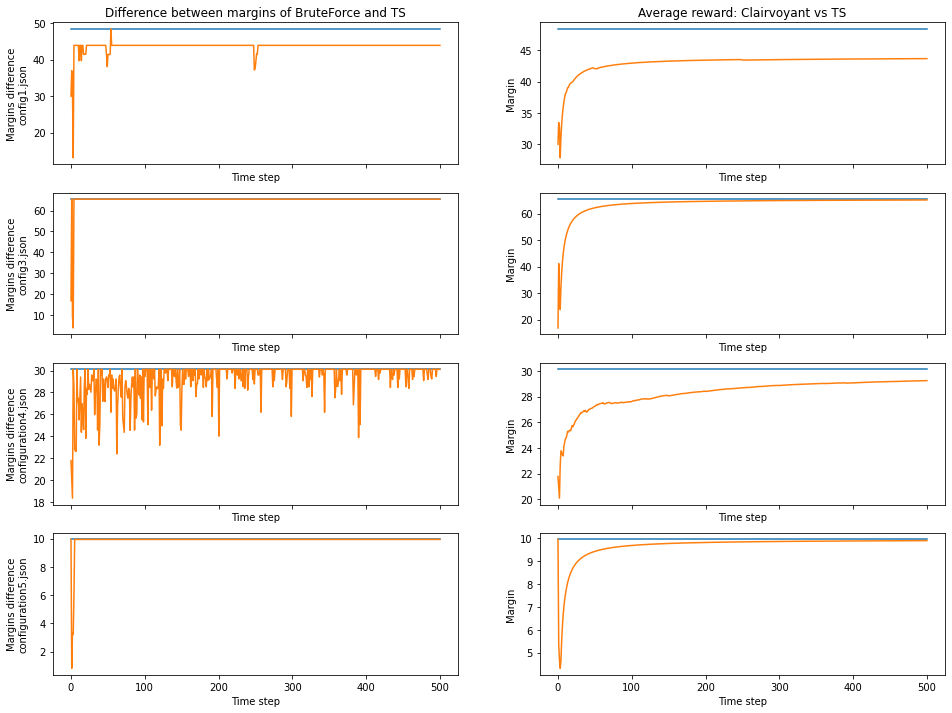

In [3]:
n_experiments = 500
fig, axes = plt.subplots(ncols=2, nrows=len(env), sharex=True, figsize=(16,12))

for i in range(0, len(env)):
    #Other UCB learner need fixing
    learner = UCB_CR(margins=config_margins[i], clickProbability=click_probs[i], alphas=alphas[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False, units_mean=units_means[i])

    ts_learner_graph_margins = np.array([])
    ts_learner_env_margins = np.array([])

    for j in range(0, n_experiments):
        ts_single_margin = 0
        opt_single_margin = 0
        armMargins = []
        armConvRates = []

        # compute the margin for the TS
        pulledArm = learner.pull_arm()
        #print (pulledArm)
        for k in range(0, len(pulledArm)):
            armMargins.append(config_margins[i][k][pulledArm[k]])
            armConvRates.append(conv_rates[i][k][pulledArm[k]])

        graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=units_means[i], verbose=False)

        env[i].setPriceLevels(pulledArm)
        ts_interactions = env[i].round()
        ts_single_margin = graphEval.computeMargin()
        #print(ts_single_margin)

        ts_env_margin = 0
        for k in range(0,len(ts_interactions)):
            # ts_env_margin = 0
            ts_env_margin = ts_env_margin + ts_interactions[k].linearizeMargin(config_margins[i])
        ts_env_margin = ts_env_margin / len(ts_interactions)

        learner.update(ts_interactions)

        ts_learner_graph_margins = np.append(ts_learner_graph_margins, ts_single_margin)
        ts_learner_env_margins = np.append(ts_learner_env_margins, ts_env_margin)

    opt_arms = optimal_arms[i]
    armMargins = []
    armConvRates = []
    for k in range(0, len(opt_arms)):
        armMargins.append(config_margins[i][k][opt_arms[k]])
        armConvRates.append(conv_rates[i][k][opt_arms[k]])
    graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=units_means[i], verbose=False)

    # optimal = np.full((n_experiments), clairvoyant_opt_rew[i])
    optimal = np.full((n_experiments), graphEval.computeMargin())

    config_name = files[i][files[i].rfind('/')-len(files[i])+1:]

    x = np.linspace(0, n_experiments, n_experiments)
    axes[i,0].plot(x, optimal)
    axes[i,0].plot(x, ts_learner_graph_margins)
    #axes[i,0].plot(x, ts_learner_env_margins)
    axes[i,0].set_xlabel("Time step")
    axes[i,0].set_ylabel("Margins difference\n{}".format(config_name))
    axes[0,0].set_title("Difference between margins of BruteForce and TS")

    axes[i,1].plot(x,optimal)
    cum_rews_graph = np.cumsum(ts_learner_graph_margins)
    avg_cum_rews_graph = np.divide(cum_rews_graph, np.arange(1,n_experiments+1))
    axes[i,1].plot(x, avg_cum_rews_graph)
    cum_rews = np.cumsum(ts_learner_env_margins)
    avg_cum_rews = np.divide(cum_rews, np.arange(1,n_experiments+1))
    #axes[i,1].plot(x, avg_cum_rews)
    axes[i,1].set_xlabel("Time step")
    axes[i,1].set_ylabel("Margin")
    axes[0,1].set_title("Average reward: Clairvoyant vs TS")
    print("Optimal arm found:\n\t", learner.pull_arm(), "\nOptimal theoretical arm:\n\t", optimal_arms[i])

plt.show()

In [4]:
#learners = UCB_CR(margins=config_margins[i], clickProbability=click_probs[i], alphas=alphas[i], secondary=prod_lists[i], Lambda=lambdas[i], debug=False)
#learner = UCB_Step4(margins=margins, clickProbability=clickProb, secondary=secondary, Lambda=Lambda, debug=True)
#learner = UCB_Step5(margins=margins, alphas=alphas, conversion_rates=conversionRates, secondary=secondary, Lambda=Lambda, debug=True)
#learner = UCB_SlidingWindow(margins=margins, clickProbability=clickProb, alphas=alphas, secondary=secondary, Lambda=Lambda, debug=False)